# **Gráficos de Séries Temporais.**

Neste exemplo nós utilizaremos a coleção Sentinel-5P NRTI AER AI: Índice de aerossol UV quase em tempo real . O AAI é baseado em mudanças dependentes do comprimento de onda no espalhamento Rayleigh na faixa espectral UV para um par de comprimentos de onda. A diferença entre a reflectância observada e modelada resulta na AAI. 

* Quando o **AAI é positivo**, indica a presença de aerossóis absorventes de UV, como poeira e fumaça. É útil para rastrear a evolução de plumas de aerossóis episódicas de surtos de poeira, cinzas vulcânicas e queima de biomassa.

* Os comprimentos de onda usados ​​têm absorção de ozônio muito baixa, portanto, diferentemente das medições de espessura óptica de aerossol, o AAI pode ser calculado na presença de nuvens. A cobertura global diária é, portanto, possível.

* Para este produto L3 AER_AI, o absorbing_aerosol_index é calculado com um par de medições nos comprimentos de onda de 354 nm e 388 nm.

Acesse - https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_AER_AI#description

# ***Instalando Bibliotecas que iremos utilizar***

In [52]:
##Instalar o pacote EE.
!pip install -q earthengine-api 

In [ ]:
##Instalando base de dados Shape do Brasil
!pip install geobr

In [ ]:
##Instalando Bibliotecas de análise espacial
!pip install geopandas

In [65]:
##Importar bibliotecas
import ee
import numpy as np
import seaborn as sns #Gerar gráficos
import geobr #Abrir os shape
import json #converter shape para json

import pandas as pd #dataframe 
import geopandas as gpd #manipular dados vetoriais

import matplotlib.pyplot as plt #plotar gráficos
%matplotlib inline
import matplotlib.colors as cls
from matplotlib import rc

import calendar

# ***Autenticação do Google Earth Engine***
Para ler/gravar de um bucket do Google Drive ou do Google Cloud Storage ao qual você tem acesso, é necessário se autenticar (como você mesmo). Você também precisará se autenticar como você mesmo com o Earth Engine, para ter acesso a seus scripts, ativos etc.

Autenticar no Earth Engine
Para acessar o Earth Engine, inscreva-se em signup.earthengine.google.com.

Identifique-se no Google Cloud para ter acesso ao armazenamento e outros recursos. Ao executar o código abaixo, ele exibirá um link na saída para uma página de autenticação em seu navegador. Siga o link para uma página que permitirá que você conceda permissão ao Google Earth Engine para acessar seus recursos. Copie o código da página de permissões de volta para este notebook e pressione Enter para concluir o processo.

In [ ]:
##Iniciar o GEE
ee.Authenticate()
ee.Initialize()


In [6]:
##Para acessar nossos arquivos devemos montar o drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Defindo área de Estudo.**

In [ ]:
# Conjuntos de dados disponíveis
geobr.list_geobr()

In [58]:
# Selecionando o Estado
state = geobr.read_state(code_state="SP", year=2018)
state

,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,35.0,SP,São Paulo,3.0,Sudeste,"MULTIPOLYGON (((-48.03781 -25.35643, -48.03638..."


In [59]:
# Município 
muni = geobr.read_municipality(code_muni=3550308 , year=2010)
muni

,code_muni,name_muni,code_state,abbrev_state,geometry
562,3550308.0,São Paulo,35.0,SP,"POLYGON ((-46.57547 -23.37402, -46.57276 -23.3..."


#***Conversação de .shp para Json - (JavaScript Object Notation)***

* GEE não permite trabalhar diretamente com arquivos .shp
* Dessa forma, realizaremos a conversão dos arquivos .shp para Json.
* Selecionaremos nossa Feature ou FeatureCollection conforme previsto no Earth Engine.  


In [ ]:
##convertendo de shp para to json
state = state.to_json()
##Carregando o arquivo json
state = json.loads(state)
##selecionando as features
state = state['features']
state

In [ ]:
##convertendo de shp para to json
muni_feature = muni.to_json()
##Carregando o arquivo json
muni_feature = json.loads(muni_feature)
##selecionando as features
muni_feature = muni_feature['features']
##Verificando o processo
muni_feature

***Definindo área de estudo utlizando o arquivo json***

In [15]:
##Definindo filtros na feature
aoi = ee.FeatureCollection(state)

In [16]:
##Definindo filtros na feature
aoi_muni = ee.FeatureCollection(muni_feature)

In [62]:
##Outra Forma! 
aoi_state = ee.FeatureCollection('users/christhianscunha/brasil_limites')\
                    .filter(ee.Filter.eq('ESTADO','SP'))

# **Definindo a Coleção de Imagens.**

In [18]:
##Coleção de Imagens 
Sentinel_5 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_AER_AI')\
                          .select('absorbing_aerosol_index')\
                          .filterDate('2019-01-01','2022-03-30')\
                          .filterBounds(aoi_state)

print('Quantas imagens estou utilizando?', Sentinel_5.size().getInfo())

Quantas imagens estou utilizando? 3039


In [78]:
##Função para extrair os valores da coleção de imagens 
#Para obter estatísticas de valores de pixel em uma região de um ee.Image, use image.reduceRegion(). 
#Isso reduz todos os pixels na(s) região(ões) a uma estatística ou outra representação 
#compacta dos dados de pixel na região (por exemplo, histograma).
##Resolução1113.2
#o número de milissegundos passados desde que a placa Arduino começou a executar o programa atual.
#Valor correspondente ao índice AAI médio para a região de estudo
def reduce_region(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_state, scale=1113.2).get('absorbing_aerosol_index')
    return img.clip(aoi_state).set('date', img.date().format())\
    .set({'millis': img.date().millis()})\
    .set('mean',mean).set('ID',img.get('system:id'))\
    .set('Orbita',img.get('ORBIT'))\

#***Map***

Uma das grandes vantagens do Google Earth Engine é aplicar um função para todas as imagens e uma coleção. Para isso utilizando o método .map().


In [79]:
## Mapear a função para cada imagem da coleção
reduced_imgs = Sentinel_5.map(reduce_region)
print(reduced_imgs.first().getInfo())

{'type': 'Image', 'bands': [{'id': 'absorbing_aerosol_index', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3517, 2358], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -46.47676467895508, 0, 0.01, -47.19224548339844]}], 'id': 'COPERNICUS/S5P/NRTI/L3_AER_AI/20190101T155350_20190101T164828', 'version': 1586161313924013, 'properties': {'date': '2019-01-01T15:53:44', 'Orbita': 6317, 'ID': 'COPERNICUS/S5P/NRTI/L3_AER_AI/20190101T155350_20190101T164828', 'millis': 1546358024000, 'LON_MIN': -46.47676467895508, 'PLATFORM': 'S5P', 'STATUS_MET_2D': 'Nominal', 'LAT_MAX': -23.60806655883789, 'ORBIT': 6317, 'TIME_REFERENCE_DAYS_SINCE_1950': 25202, 'LAT_MIN': -47.19224548339844, 'BUILD_DATE': 1542290700000, 'INSTITUTION': 'KNMI', 'system:time_end': 1546358336000, 'SENSOR': 'TROPOMI', 'L3_PROCESSING_VERSION': '20200331', 'PRODUCT_ID': 'S5P_NRTI_L2__AER_AI_20190101T155350_20190101T155850_06317_01_010202_20190101T164828', 'PRODUCT_QUALITY': 'NOMINAL', 'PROCESSOR_VERSION': '1

In [80]:
#verificando nossa coleção após o método map
reduced_imgs.size().getInfo()

3039

In [81]:
##Propriedades da Imagem
reduced_imgs.first().propertyNames().getInfo()

['date',
 'Orbita',
 'ID',
 'millis',
 'LON_MIN',
 'system:id',
 'PLATFORM',
 'STATUS_MET_2D',
 'LAT_MAX',
 'ORBIT',
 'system:version',
 'TIME_REFERENCE_DAYS_SINCE_1950',
 'LAT_MIN',
 'BUILD_DATE',
 'INSTITUTION',
 'system:time_end',
 'SENSOR',
 'L3_PROCESSING_VERSION',
 'PRODUCT_ID',
 'PRODUCT_QUALITY',
 'PROCESSOR_VERSION',
 'LON_MAX',
 'PROCESSING_STATUS',
 'system:time_start',
 'HARP_VERSION',
 'TRACKING_ID',
 'SPATIAL_RESOLUTION',
 'ALGORITHM_VERSION',
 'L3_PROCESSING_TIME',
 'system:asset_size',
 'TIME_REFERENCE_JULIAN_DAY',
 'system:index',
 'system:bands',
 'system:band_names']

#***Preparando nosso dataframe***

Temos a média do AAI correspondente a nossa região. Neste sentido, vamos converter nossos dados para colunas, selecionando a base que queremos que componham nosso dataframe.

In [82]:
#Para converter em um dataframe pandas, não queremos um ImageCollection; no entanto, reduziremos nossas imagens a uma lista de listas:
nested_list = reduced_imgs.reduceColumns(ee.Reducer.toList(5), ['date','mean','millis','ID', 'Orbita']).values().get(0)

In [83]:
#Essa lista aninhada pode ser transformada em um dataframe usando o .DataFrameconstrutor. Vamos nomear as colunas, “data” e “média”.
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean','millis','ID','Orbita'])
df

,date,mean,millis,ID,Orbita
0,2019-01-01T15:58:44,-1.552874,1546358324000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190101T155850_...,6317
1,2019-01-01T17:38:45,-0.682804,1546364325000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190101T173850_...,6318
2,2019-01-02T17:18:44,-0.829540,1546449524000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190102T171850_...,6332
3,2019-01-03T16:58:45,-1.148141,1546534725000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190103T165850_...,6346
4,2019-01-03T17:03:45,-1.363227,1546535025000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190103T170350_...,6346
...,...,...,...,...,...
2231,2022-03-18T18:05:15,0.450173,1647626715000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220318T180521_...,22946
2232,2022-03-19T16:05:15,-1.134352,1647705915000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220319T160521_...,22959
2233,2022-03-19T17:45:16,0.414707,1647711916000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220319T174521_...,22960
2234,2022-03-20T15:45:15,-1.144736,1647791115000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220320T154521_...,22973


In [84]:
# Função para adicionar variáveis de data ao DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [85]:
 ##Agora temos um dataframe com cada observação (mês) como uma linha e tem o timestamp e os valores médios.
 ##ambém definiremos nossa coluna de data para ser nosso índice. Fazer essas coisas permite que nossa 
 ##.plotbiblioteca converta automaticamente as datas em datas legíveis em nosso eixo.
date_df = add_date_info(df)
date_df

,date,mean,millis,ID,Orbita,Timestamp,Year,Month,Day,DOY
0,2019-01-01T15:58:44,-1.552874,1546358324000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190101T155850_...,6317,2019-01-01 15:58:44,2019,1,1,1
1,2019-01-01T17:38:45,-0.682804,1546364325000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190101T173850_...,6318,2019-01-01 17:38:45,2019,1,1,1
2,2019-01-02T17:18:44,-0.829540,1546449524000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190102T171850_...,6332,2019-01-02 17:18:44,2019,1,2,2
3,2019-01-03T16:58:45,-1.148141,1546534725000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190103T165850_...,6346,2019-01-03 16:58:45,2019,1,3,3
4,2019-01-03T17:03:45,-1.363227,1546535025000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190103T170350_...,6346,2019-01-03 17:03:45,2019,1,3,3
...,...,...,...,...,...,...,...,...,...,...
2231,2022-03-18T18:05:15,0.450173,1647626715000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220318T180521_...,22946,2022-03-18 18:05:15,2022,3,18,77
2232,2022-03-19T16:05:15,-1.134352,1647705915000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220319T160521_...,22959,2022-03-19 16:05:15,2022,3,19,78
2233,2022-03-19T17:45:16,0.414707,1647711916000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220319T174521_...,22960,2022-03-19 17:45:16,2022,3,19,78
2234,2022-03-20T15:45:15,-1.144736,1647791115000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220320T154521_...,22973,2022-03-20 15:45:15,2022,3,20,79


# **CRIANDO GRÁFICOS**

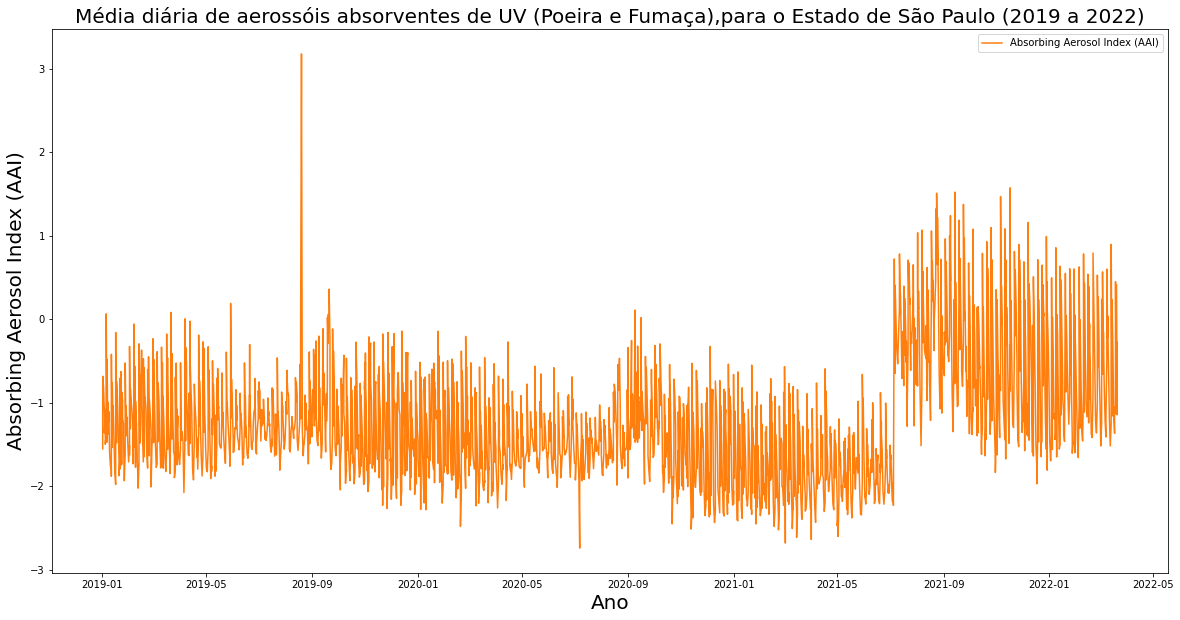

In [86]:
# criamos uma figura com pyplot e definimos as dimensões para 15 x 7
fig, ax = plt.subplots(figsize=(20,10))

# vamos criar o gráfico definindo nosso dataframe para o argumento de dados
sns.lineplot(data=date_df, x= 'Timestamp', y='mean', color='C1', ax=ax, label='Absorbing Aerosol Index (AAI)')

# vamos definir os rótulos e o título
ax.set_ylabel('Absorbing Aerosol Index (AAI)',fontsize=20)
ax.set_xlabel('Ano',fontsize=20)
ax.set_title('Média diária de aerossóis absorventes de UV (Poeira e Fumaça),para o Estado de São Paulo (2019 a 2022)',fontsize=20);

# **Análises estatísticas**

In [87]:
#definiremos nossa coluna de data para ser nosso índice. 
date_df['date'] = pd.to_datetime(date_df['date'])
date_df = date_df.set_index('date')
date_df

,mean,millis,ID,Orbita,Timestamp,Year,Month,Day,DOY
date,,,,,,,,,
2019-01-01 15:58:44,-1.552874,1546358324000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190101T155850_...,6317,2019-01-01 15:58:44,2019,1,1,1
2019-01-01 17:38:45,-0.682804,1546364325000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190101T173850_...,6318,2019-01-01 17:38:45,2019,1,1,1
2019-01-02 17:18:44,-0.829540,1546449524000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190102T171850_...,6332,2019-01-02 17:18:44,2019,1,2,2
2019-01-03 16:58:45,-1.148141,1546534725000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190103T165850_...,6346,2019-01-03 16:58:45,2019,1,3,3
2019-01-03 17:03:45,-1.363227,1546535025000,COPERNICUS/S5P/NRTI/L3_AER_AI/20190103T170350_...,6346,2019-01-03 17:03:45,2019,1,3,3
...,...,...,...,...,...,...,...,...,...
2022-03-18 18:05:15,0.450173,1647626715000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220318T180521_...,22946,2022-03-18 18:05:15,2022,3,18,77
2022-03-19 16:05:15,-1.134352,1647705915000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220319T160521_...,22959,2022-03-19 16:05:15,2022,3,19,78
2022-03-19 17:45:16,0.414707,1647711916000,COPERNICUS/S5P/NRTI/L3_AER_AI/20220319T174521_...,22960,2022-03-19 17:45:16,2022,3,19,78


In [88]:
#Vamos analisar os extremos? 
date_df['mean'].idxmax()

Timestamp('2019-08-19 17:26:04')

In [89]:
#Vamos analisar os extremos? 
date_df['mean'].idxmin()

Timestamp('2020-07-06 16:44:02')

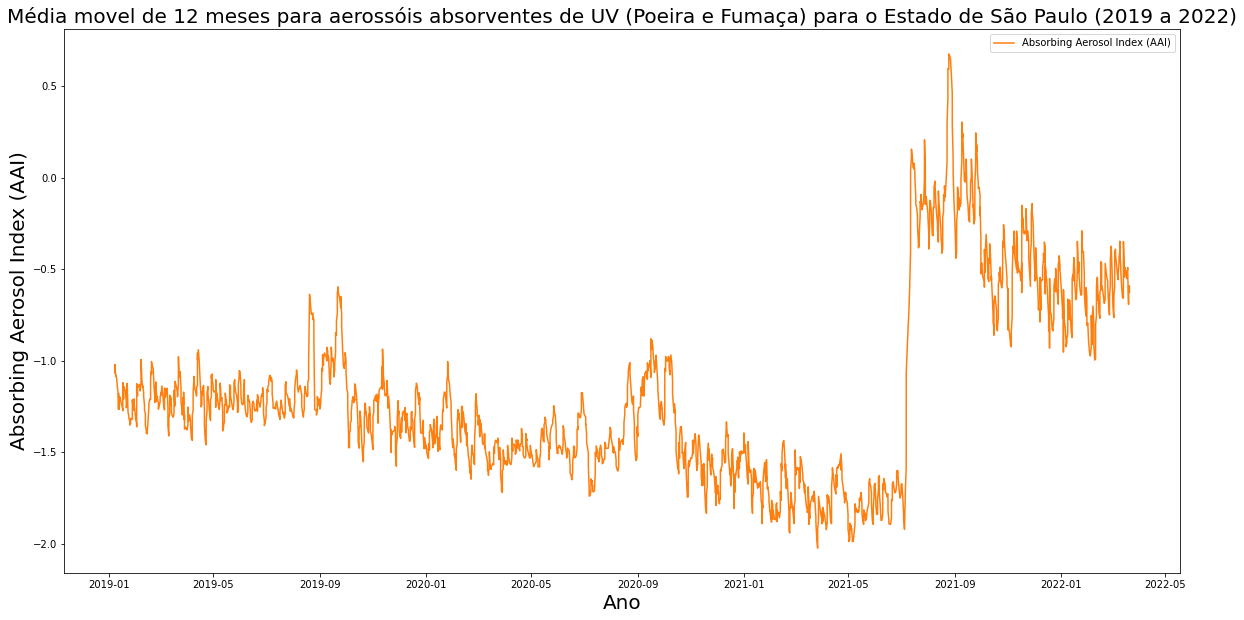

In [90]:
##Analisando a média móvel
# criamos uma figura com pyplot e definimos as dimensões para 15 x 7
fig, ax = plt.subplots(figsize=(20,10))

# vamos criar o gráfico definindo nosso dataframe para o argumento de dados
janela = 12
sns.lineplot(data=date_df.rolling(janela).mean(), x= 'date', y='mean', color='C1', ax=ax, label='Absorbing Aerosol Index (AAI)')

# vamos definir os rótulos e o título
ax.set_ylabel('Absorbing Aerosol Index (AAI)',fontsize=20)
ax.set_xlabel('Ano',fontsize=20)
ax.set_title(f'Média movel de {janela} meses para aerossóis absorventes de UV (Poeira e Fumaça) para o Estado de São Paulo (2019 a 2022)',fontsize=20);

# **Plotando Imagens para comparar.**

In [ ]:
##Instalar pacote geemap
!pip install -q geemap

In [44]:
##Import a biblioteca
import geemap

In [73]:
##Imagens por data
img_max = ee.Image('COPERNICUS/S5P/NRTI/L3_AER_AI/20190819T172609_20190819T181237').clip(aoi_state)
img_min = ee.Image('COPERNICUS/S5P/NRTI/L3_AER_AI/20210402T172609_20210402T181051').clip(aoi_state)

print(img_max.get('BUILD_DATE').getInfo())
print(img_min.get('BUILD_DATE').getInfo())

1554465840000
1554465840000


In [46]:
Mapa = geemap.Map()
Mapa.centerObject(aoi, zoom=7)
Mapa.add_basemap("SATELLITE")

##Adicionando nossas imagens 
Mapa.addLayer(img_min.select('absorbing_aerosol_index'), {'palette':['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red'],'min':-2,'max':2}, "Absorbing Aerosol Index (AAI) min")
Mapa.addLayer(img_max.select('absorbing_aerosol_index'), {'palette':['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red'],'min':-2,'max':2}, "Absorbing Aerosol Index (AAI) max")

##Limite de SP
image = ee.Image().paint(aoi_muni, 0, 2)
Mapa.addLayer(image, {'palette': ['black']}, 'São Paulo')

##Adicionando ferramentas e plotar o gráfico
Mapa.addLayerControl()
Mapa

Map(center=[-22.264310260902384, -48.740553850667986], controls=(WidgetControl(options=['position', 'transpare…

#***Análise Mensal***

In [91]:
date_df_year= date_df.groupby(['Year'])['mean'].mean().reset_index()
date_df_year

,Year,mean
0,2019,-1.204243
1,2020,-1.427905
2,2021,-1.033328
3,2022,-0.635534


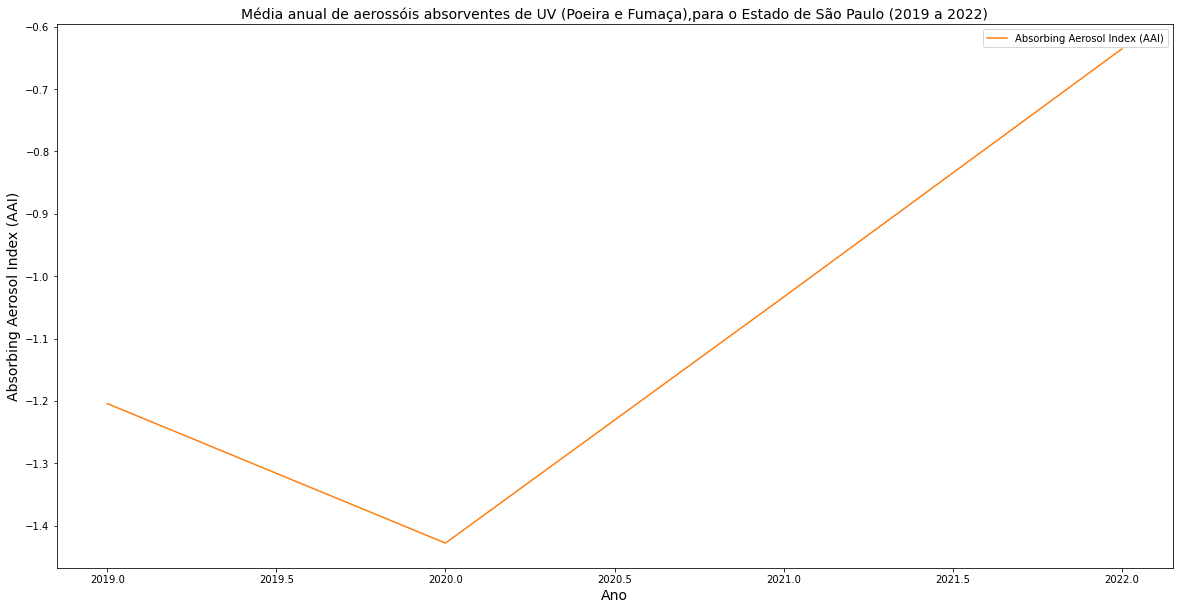

In [92]:
# criamos uma figura com pyplot e definimos as dimensões para 15 x 7
fig, ax = plt.subplots(figsize=(20,10))

# vamos criar o gráfico definindo nosso dataframe para o argumento de dados
sns.lineplot(data=date_df_year, x= 'Year', y='mean', color='C1', ax=ax, label='Absorbing Aerosol Index (AAI)')

# vamos definir os rótulos e o título
ax.set_ylabel('Absorbing Aerosol Index (AAI)',fontsize=14)
ax.set_xlabel('Ano',fontsize=14)
ax.set_title('Média anual de aerossóis absorventes de UV (Poeira e Fumaça),para o Estado de São Paulo (2019 a 2022)',fontsize=14);

In [93]:
date_df_month= date_df.groupby(['Month'])['mean'].mean().reset_index()
date_df_month

,Month,mean
0,1,-1.231304
1,2,-1.259770
2,3,-1.340539
3,4,-1.466510
4,5,-1.479183
5,6,-1.472134
6,7,-1.008007
7,8,-0.829153
8,9,-0.698786
9,10,-1.099842


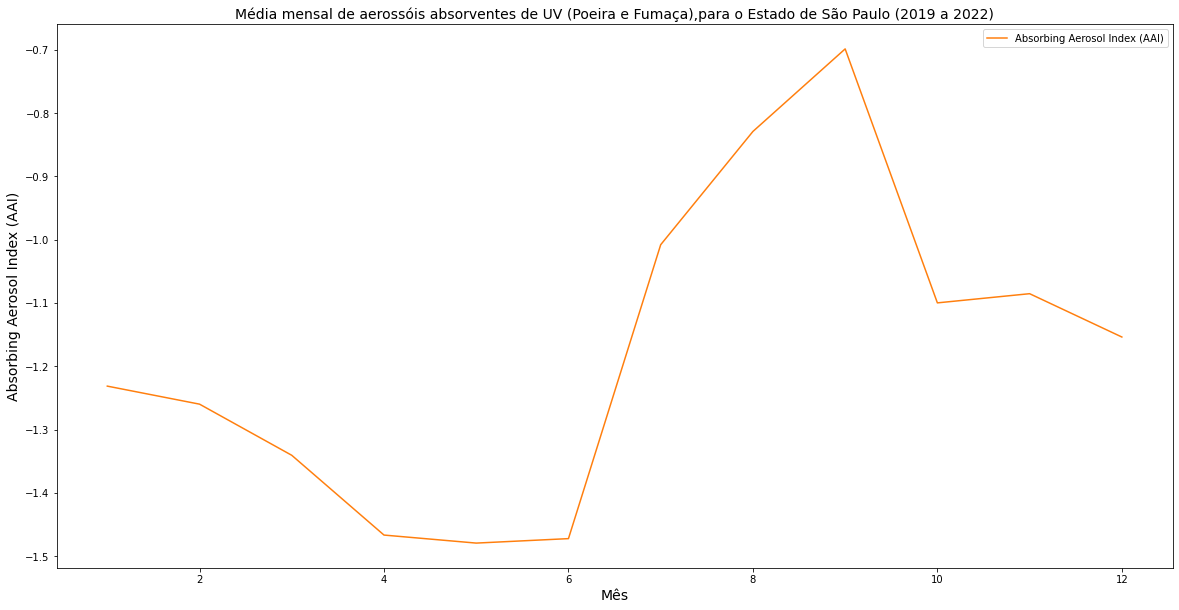

In [94]:
# criamos uma figura com pyplot e definimos as dimensões para 15 x 7
fig, ax = plt.subplots(figsize=(20,10))

# vamos criar o gráfico definindo nosso dataframe para o argumento de dados
sns.lineplot(data=date_df_month, x= 'Month', y='mean', color='C1', ax=ax, label='Absorbing Aerosol Index (AAI)')

# vamos definir os rótulos e o título
ax.set_ylabel('Absorbing Aerosol Index (AAI)',fontsize=14)
ax.set_xlabel('Mês',fontsize=14)
ax.set_title('Média mensal de aerossóis absorventes de UV (Poeira e Fumaça),para o Estado de São Paulo (2019 a 2022)',fontsize=14);

Referencias 

https://worldbank.github.io/OpenNightLights/tutorials/mod4_1_time_series_charts.html


https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

https://samprafael.medium.com/plotando-dados-netcdf-e-shapefile-com-python-e-geopandas-f6252ed4308e